# Capítulo 2

## Create a test set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit  

In [2]:
path = "datasets/housing /housing.csv"
housing = pd.read_csv(path)

In [3]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])

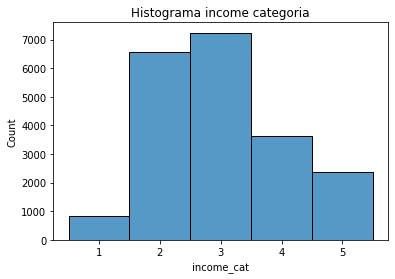

In [4]:
sns.histplot(data=housing, x="income_cat")
plt.title("Histograma income categoria")
plt.show()

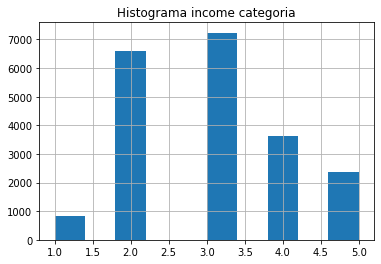

In [5]:
housing.income_cat.hist()
plt.title("Histograma income categoria")
plt.show()

A veces es necesario crear splits estratificados, para que el porcentage de categorias o valores este bien distribuido en cada set de prueba, esto será de suma importancia más adelante en el cross-validation

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing.income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [8]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [9]:
housing = strat_train_set.copy()

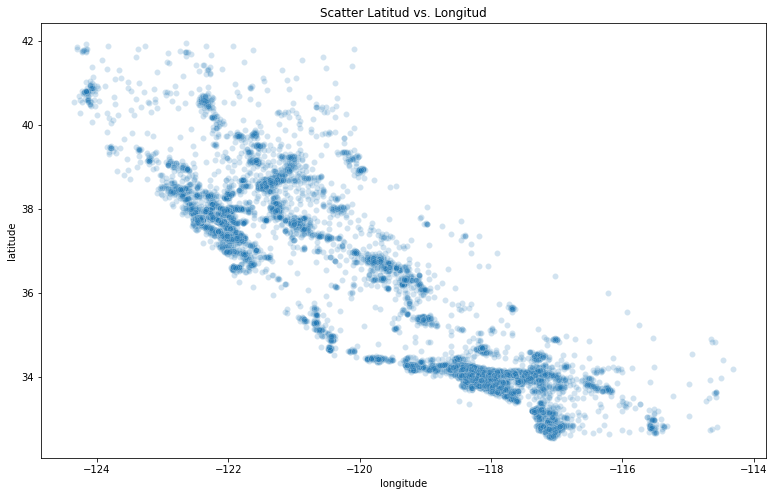

In [10]:
sns.scatterplot(data=housing, x="longitude", y="latitude", alpha=0.2)
figure = plt.gcf()
figure.set_size_inches(13, 8)
plt.title("Scatter Latitud vs. Longitud")
plt.show()

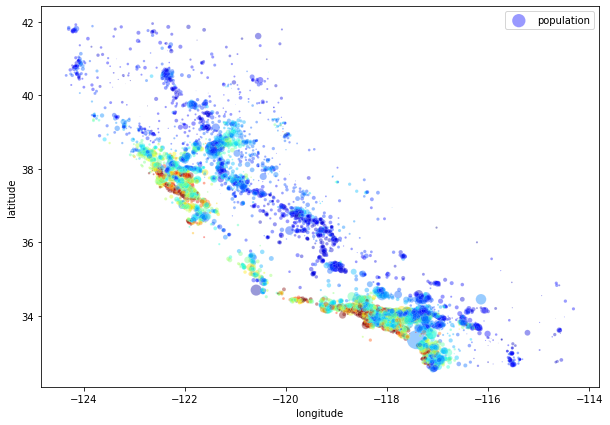

In [11]:
sns.scatterplot(data=housing, x="longitude", y="latitude", alpha=0.4, s=housing.population/100, label="population",\
               c=housing.median_house_value, cmap=plt.get_cmap("jet"))
figure = plt.gcf()
figure.set_size_inches(10, 7)
plt.show()

In [12]:
corr_matrix = housing.corr()

In [13]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

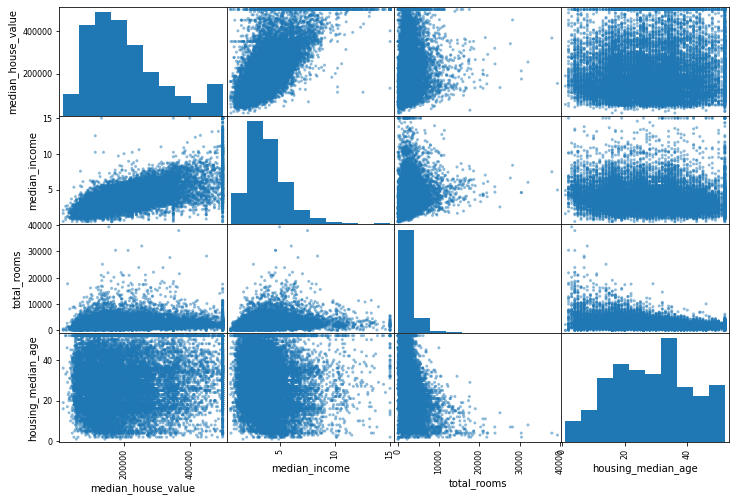

In [14]:
attributes=["median_house_value", "median_income", "total_rooms", "housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes],figsize=(12,8))
plt.show()

In [15]:
housing.eval("rooms_peer_household = total_rooms/households", inplace=True)
housing.eval("bedrooms_peer_household = total_bedrooms/total_rooms", inplace=True)
housing.eval("population_peer_household = population/households", inplace=True)

In [16]:
corelation = housing.corr()
corelation.median_house_value.sort_values(ascending=False)

median_house_value           1.000000
median_income                0.687151
rooms_peer_household         0.146255
total_rooms                  0.135140
housing_median_age           0.114146
households                   0.064590
total_bedrooms               0.047781
population_peer_household   -0.021991
population                  -0.026882
longitude                   -0.047466
latitude                    -0.142673
bedrooms_peer_household     -0.259952
Name: median_house_value, dtype: float64

In [17]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set.median_house_value.copy()

## SimpleImputer

In [18]:
from sklearn.impute import SimpleImputer

In [19]:
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1)

In [20]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [21]:
X = imputer.transform(housing_num)

In [22]:
housing_cat = housing[["ocean_proximity"]]

## OrdinalEncoder

In [23]:
from sklearn.preprocessing import OrdinalEncoder

In [24]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoder = ordinal_encoder.fit_transform(housing_cat)

In [25]:
housing_cat_encoder

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

## OneHotEncoder

In [26]:
from sklearn.preprocessing import OneHotEncoder

In [27]:
one_hot = OneHotEncoder()
housing_cat_1hot = one_hot.fit_transform(housing_cat)

In [28]:
one_hot.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Pipeline

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class AddTransformFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_peer_household = X[:, rooms_ix] / X[: , household_ix]
        population_peer_household = X[:, population_ix] / X[: , household_ix]
        
        if self.add_bedrooms_per_room == True:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_peer_household, population_peer_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_peer_household, population_peer_household]

In [30]:
try:
    housing_num = housing_num.drop(columns=["rooms_peer_household", "bedrooms_peer_household", "population_peer_household"])
except KeyError:
    print("Las columnas ya han sido eliminadas")

Las columnas ya han sido eliminadas


In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [32]:
pipeline_num = Pipeline([("imputer", SimpleImputer(strategy="median")), 
                        ("attribs_adder", AddTransformFeatures()),
                        ("std_scaler", StandardScaler())])

In [33]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", pipeline_num, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
# tree_reg.fit(housing_prepared, housing_labels)
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [35]:
def print_scores(scores: np.array):
    print("Scores:\n", scores)
    print("Mean:\n", scores.mean())
    print("Std\n", scores.std())

In [36]:
print_scores(tree_rmse_scores)

Scores:
 [72616.09382976 69135.10616815 70395.72832044 73754.34505971
 68141.17989773 77596.97490188 70236.96398216 73671.72573916
 68383.26294968 70885.03088401]
Mean:
 71481.64117326755
Std
 2792.7615428925387


## joblib

In [37]:
import joblib

In [38]:
joblib.dump(tree_reg, "my_model.pkl")

['my_model.pkl']

In [39]:
load_model = joblib.load("my_model.pkl")

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [41]:
param_grid = [{"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
              {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]}]
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)

In [42]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [43]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [44]:
extra_attribs = ["rooms_peer_hhoold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = cat_encoder.categories_[0].tolist()
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [45]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted((zip(feature_importances, attributes)), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204354, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_peer_hhoold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887776, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

In [46]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)

In [47]:
final_predictions = final_model.predict(X_test_prepared)

In [48]:
from sklearn.metrics import mean_squared_error

In [49]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

47873.26095812988


In [50]:
final_model.score(X_test_prepared, y_test)

0.8241523278259953

In [51]:
from scipy import stats

In [52]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
degree_freedom = squared_errors.size - 1
sample_mean = squared_errors.mean()
sample_sem = stats.sem(squared_errors)
interval = np.sqrt(stats.t.interval(confidence, degree_freedom, sample_mean, sample_sem))
print(interval)

[45893.36082829 49774.46796717]


## Exercices

### 1. Try a Support Vector Machine regressor (sklearn.svm.SVM)
various hyperparameters, such as kernel=linear (with various
values for the C hyperparameter) or
values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best
predictor perform?

In [58]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [69]:
param_svr_grid = [
                  {"kernel":["linear"], "C":[0.01, 1, 10, 100]},
                  {"kernel":["rbf"], "C":[0.01, 10, 100], "gamma": [0.01, 0.1, 3]}
]
svr = SVR()
grid_svr = GridSearchCV(svr, param_svr_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)                                                                     

In [70]:
grid_svr.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.01, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.01, 10, 100], 'gamma': [0.01, 0.1, 3],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
grid_svr.best_estimator_

SVR(C=100, kernel='linear')

### 2. Try replacing GridSerchCv with RandomizedSearchCV

In [74]:
from scipy.stats import reciprocal, expon
from sklearn.model_selection import RandomizedSearchCV
param_svr_random = [{"kernel":["linear", "rbf"], "C":reciprocal(20, 16000), "gamma": expon(scale=1.0)}]

In [75]:
random_svr = RandomizedSearchCV(svr, param_svr_random, cv=5,
                                n_iter=25, random_state=42, verbose=2, scoring="neg_mean_squared_error")

In [77]:
random_svr.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END C=244.54211522321074, gamma=3.010121430917521, kernel=linear; total time=   3.2s
[CV] END C=244.54211522321074, gamma=3.010121430917521, kernel=linear; total time=   3.1s
[CV] END C=244.54211522321074, gamma=3.010121430917521, kernel=linear; total time=   3.1s
[CV] END C=244.54211522321074, gamma=3.010121430917521, kernel=linear; total time=   3.1s
[CV] END C=244.54211522321074, gamma=3.010121430917521, kernel=linear; total time=   3.3s
[CV] END C=3668.9613053861285, gamma=0.9084469696321253, kernel=rbf; total time=   4.9s
[CV] END C=3668.9613053861285, gamma=0.9084469696321253, kernel=rbf; total time=   4.9s
[CV] END C=3668.9613053861285, gamma=0.9084469696321253, kernel=rbf; total time=   4.9s
[CV] END C=3668.9613053861285, gamma=0.9084469696321253, kernel=rbf; total time=   5.0s
[CV] END C=3668.9613053861285, gamma=0.9084469696321253, kernel=rbf; total time=   4.9s
[CV] END C=56.74088766251674, gamma=0.0598387686

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=25,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1777132e0>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1680f6710>,
                                         'kernel': ['linear', 'rbf']}],
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [78]:
random_svr.best_params_

{'C': 13425.482171640471, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

### 3. Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [118]:
from sklearn.base import BaseEstimator, TransformerMixin

In [112]:
class MostImportantFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, features: np.array, k: int):
        self.features = features
        self.k = k
    
    def fit(self, X, y=None):
        self.features_indixes = np.sort(np.argpartition(self.features, -self.k)[-self.k:])
        return self
    
    def transform(self, X):
        return X[:, self.features_indixes]

In [91]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [114]:
new_pipeline = Pipeline([("preparation", full_pipeline), ("Best_Col", MostImportantFeatures(feature_importances, 5))])

In [119]:
new_housing_prepared = new_pipeline.fit_transform(housing)
new_housing_prepared

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ],
       ...,
       [-1.5707942 ,  1.31001828, -0.36547546, -0.03743619,  0.        ],
       [-1.56080303,  1.2492109 ,  0.16826095, -0.05915604,  0.        ],
       [-1.28105026,  2.02567448, -0.390569  ,  0.00657083,  1.        ]])

### 4. Try creating a single pipeline that does the full data preparation plus the final prediction.

In [121]:
final_pipeline = Pipeline([("full", full_pipeline),
                           ("Best_features", MostImportantFeatures(feature_importances, 5)),
                           ("SVR", SVR(**random_svr.best_params_))])

In [125]:
final_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('full',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   AddTransformFeatures()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                              

### 5. Automatically explore some preparation options using GridSearchCv.

In [144]:
full_pipeline.named_transformers_["cat"].ValueError = 'ignore'
param_grid = [{
    'full__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'Best_features__k': [1, 2, 3, 4, 5]
}]

grid_search_prep = GridSearchCV(final_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=1, full__num__imputer__strategy=mean; total time=   2.9s
[CV] END Best_features__k=1, full__num__imputer__strategy=mean; total time=   4.3s
[CV] END Best_features__k=1, full__num__imputer__strategy=mean; total time=   4.3s
[CV] END Best_features__k=1, full__num__imputer__strategy=mean; total time=   4.3s
[CV] END Best_features__k=1, full__num__imputer__strategy=mean; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=1, full__num__imputer__strategy=median; total time=   2.9s
[CV] END Best_features__k=1, full__num__imputer__strategy=median; total time=   4.3s
[CV] END Best_features__k=1, full__num__imputer__strategy=median; total time=   4.3s
[CV] END Best_features__k=1, full__num__imputer__strategy=median; total time=   4.2s
[CV] END Best_features__k=1, full__num__imputer__strategy=median; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=1, full__num__imputer__strategy=most_frequent; total time=   2.9s
[CV] END Best_features__k=1, full__num__imputer__strategy=most_frequent; total time=   4.3s
[CV] END Best_features__k=1, full__num__imputer__strategy=most_frequent; total time=   4.4s
[CV] END Best_features__k=1, full__num__imputer__strategy=most_frequent; total time=   4.4s
[CV] END Best_features__k=1, full__num__imputer__strategy=most_frequent; total time=   4.3s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=2, full__num__imputer__strategy=mean; total time=   3.1s
[CV] END Best_features__k=2, full__num__imputer__strategy=mean; total time=   4.6s
[CV] END Best_features__k=2, full__num__imputer__strategy=mean; total time=   4.5s
[CV] END Best_features__k=2, full__num__imputer__strategy=mean; total time=   4.5s
[CV] END Best_features__k=2, full__num__imputer__strategy=mean; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=2, full__num__imputer__strategy=median; total time=   3.0s
[CV] END Best_features__k=2, full__num__imputer__strategy=median; total time=   4.4s
[CV] END Best_features__k=2, full__num__imputer__strategy=median; total time=   4.5s
[CV] END Best_features__k=2, full__num__imputer__strategy=median; total time=   4.5s
[CV] END Best_features__k=2, full__num__imputer__strategy=median; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=2, full__num__imputer__strategy=most_frequent; total time=   3.0s
[CV] END Best_features__k=2, full__num__imputer__strategy=most_frequent; total time=   4.4s
[CV] END Best_features__k=2, full__num__imputer__strategy=most_frequent; total time=   4.5s
[CV] END Best_features__k=2, full__num__imputer__strategy=most_frequent; total time=   4.6s
[CV] END Best_features__k=2, full__num__imputer__strategy=most_frequent; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=3, full__num__imputer__strategy=mean; total time=   3.1s
[CV] END Best_features__k=3, full__num__imputer__strategy=mean; total time=   4.6s
[CV] END Best_features__k=3, full__num__imputer__strategy=mean; total time=   4.6s
[CV] END Best_features__k=3, full__num__imputer__strategy=mean; total time=   4.6s
[CV] END Best_features__k=3, full__num__imputer__strategy=mean; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=3, full__num__imputer__strategy=median; total time=   3.1s
[CV] END Best_features__k=3, full__num__imputer__strategy=median; total time=   4.6s
[CV] END Best_features__k=3, full__num__imputer__strategy=median; total time=   4.6s
[CV] END Best_features__k=3, full__num__imputer__strategy=median; total time=   4.6s
[CV] END Best_features__k=3, full__num__imputer__strategy=median; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=3, full__num__imputer__strategy=most_frequent; total time=   3.1s
[CV] END Best_features__k=3, full__num__imputer__strategy=most_frequent; total time=   4.6s
[CV] END Best_features__k=3, full__num__imputer__strategy=most_frequent; total time=   4.6s
[CV] END Best_features__k=3, full__num__imputer__strategy=most_frequent; total time=   4.6s
[CV] END Best_features__k=3, full__num__imputer__strategy=most_frequent; total time=   4.7s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=4, full__num__imputer__strategy=mean; total time=   3.0s
[CV] END Best_features__k=4, full__num__imputer__strategy=mean; total time=   4.5s
[CV] END Best_features__k=4, full__num__imputer__strategy=mean; total time=   4.4s
[CV] END Best_features__k=4, full__num__imputer__strategy=mean; total time=   4.4s
[CV] END Best_features__k=4, full__num__imputer__strategy=mean; total time=   4.4s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=4, full__num__imputer__strategy=median; total time=   3.1s
[CV] END Best_features__k=4, full__num__imputer__strategy=median; total time=   4.4s
[CV] END Best_features__k=4, full__num__imputer__strategy=median; total time=   4.4s
[CV] END Best_features__k=4, full__num__imputer__strategy=median; total time=   4.4s
[CV] END Best_features__k=4, full__num__imputer__strategy=median; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=4, full__num__imputer__strategy=most_frequent; total time=   3.1s
[CV] END Best_features__k=4, full__num__imputer__strategy=most_frequent; total time=   4.6s
[CV] END Best_features__k=4, full__num__imputer__strategy=most_frequent; total time=   4.5s
[CV] END Best_features__k=4, full__num__imputer__strategy=most_frequent; total time=   4.5s
[CV] END Best_features__k=4, full__num__imputer__strategy=most_frequent; total time=   4.5s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=5, full__num__imputer__strategy=mean; total time=   3.1s
[CV] END Best_features__k=5, full__num__imputer__strategy=mean; total time=   4.6s
[CV] END Best_features__k=5, full__num__imputer__strategy=mean; total time=   4.6s
[CV] END Best_features__k=5, full__num__imputer__strategy=mean; total time=   4.6s
[CV] END Best_features__k=5, full__num__imputer__strategy=mean; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=5, full__num__imputer__strategy=median; total time=   3.1s
[CV] END Best_features__k=5, full__num__imputer__strategy=median; total time=   4.7s
[CV] END Best_features__k=5, full__num__imputer__strategy=median; total time=   4.7s
[CV] END Best_features__k=5, full__num__imputer__strategy=median; total time=   4.6s
[CV] END Best_features__k=5, full__num__imputer__strategy=median; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 258, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, me

[CV] END Best_features__k=5, full__num__imputer__strategy=most_frequent; total time=   3.1s
[CV] END Best_features__k=5, full__num__imputer__strategy=most_frequent; total time=   4.6s
[CV] END Best_features__k=5, full__num__imputer__strategy=most_frequent; total time=   4.6s
[CV] END Best_features__k=5, full__num__imputer__strategy=most_frequent; total time=   4.6s
[CV] END Best_features__k=5, full__num__imputer__strategy=most_frequent; total time=   4.6s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('full',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          AddTransformFeatures()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                 